In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection


In [2]:
amazon = pd.read_csv("Reviews.csv")

In [3]:
amazon.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
amazon.shape

(568454, 10)

In [5]:
lst=[]
for i in amazon['Score']:
    if i < 3:
        lst.append(0)
    elif i == 3:
        lst.append(3)
    else:
        lst.append(1)

amazon['Score'] = lst

In [6]:
amazon.shape

(568454, 10)

In [7]:
amazon = amazon[amazon['Score'] != 3]

In [8]:
amazon['Score'].unique()

array([1, 0], dtype=int64)

In [9]:
from datetime import datetime
amazon['Date'] = pd.to_datetime(amazon['Time'],unit='s')

In [10]:
amazon.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07


In [11]:
del amazon['Time']
amazon.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07


In [12]:
amazon.shape

(525814, 10)

In [13]:
amazon.drop_duplicates(subset = {"UserId", "ProfileName", "Date", "Text"}, keep = "first", inplace = True)

In [14]:
amazon.shape

(364173, 10)

In [15]:
amazon['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [16]:
final_dataset=amazon[['Text','Score']]

In [17]:
final_dataset.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [18]:
data_p=final_dataset[final_dataset['Score']==1]
data_n=final_dataset[final_dataset['Score']==0]
len(data_p),len(data_n)

(307063, 57110)

In [19]:
data_p = data_p[0 : 57110][:]

In [20]:
len(data_p)

57110

In [21]:
data=pd.concat([data_p,data_n])
len(data)

114220

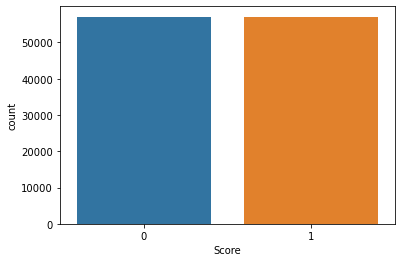

In [22]:
import seaborn as sns
sns.countplot(data['Score'])

In [23]:
!pip install bs4
from bs4 import BeautifulSoup
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
data['review']=data['Text'].apply(strip_html)
data.head(2)

,Text,Score,review
0,I have bought several of the Vitality canned d...,1,I have bought several of the Vitality canned d...
2,This is a confection that has been around a fe...,1,This is a confection that has been around a fe...


In [24]:
data=data.drop('Text',axis=1)
import nltk 
def punc_clean(text):
    import string as st
    a=[w for w in text if w not in st.punctuation]
    return ''.join(a)
data['review']=data['review'].apply(punc_clean)
data.head(2)

,Score,review
0,1,I have bought several of the Vitality canned d...
2,1,This is a confection that has been around a fe...


In [29]:
stop = ["i","me","my","myself","we","our","ours","ourselves","you",
        "your","yours","yourself","yourselves","he","him","his",
        "himself","she","her","hers","herself","it","its","itself",
        "they","them","their","theirs","themselves","what","which",
        "whom","these","who","those","am","is","are","was","were","be",
        "been","being","have","has","had","having","do","does","did",
        "doing","a","an","the","and","but","if","or","because","as",
        "until","while","of","at","by","for","with","about","against",
        "between","into","through","during","before","after","above",
        "below","to","from","up","down","in","out","on","off""over",
        "under","again","further","then","once","here","there","when",
        "where","why","how","all","any","both","each","few","more","most",
        "other","some","such","only","own","same","so","than""too","very",
        "s","t""can","will","just","should","now","this"]


In [30]:
data['review'] = data['review'].str.replace("[^\w\s]", "").str.lower()

data['review'] = data['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [31]:
data['review'].head()

0    bought several vitality canned dog food produc...
2    confection that around centuries light pillowy...
4    great taffy great price wide assortment yummy ...
5    got wild hair taffy ordered five pound bag taf...
6    saltwater taffy great flavors soft chewy candy...
Name: review, dtype: object

In [32]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectr=TfidfVectorizer(ngram_range=(1,2))
vectr.fit(data['review'])
vect_X=vectr.transform(data['review'])

In [33]:
pickle.dump(vectr, open('tranform.pkl', 'wb'))

In [74]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression().fit(vect_X,data['Score'])
clf.score(vect_X,data['Score'])


0.955559446681842

In [75]:
clf.predict(vectr.transform(['i like this food']))

array([0], dtype=int64)

In [76]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=7).fit(vect_X,data['Score'])
clf1.score(vect_X,data['Score'])


0.8789791630187358

In [77]:
clf1.predict(vectr.transform(['i like this food']))

array([0], dtype=int64)

In [34]:
from sklearn.naive_bayes import MultinomialNB
clf2 = MultinomialNB().fit(vect_X,data['Score'])
clf2.score(vect_X,data['Score'])

0.9733934512344599

In [44]:
clf2.predict(vectr.transform(['You are not beautiful']))

array([1], dtype=int64)

In [45]:
filename = 'nlp_model.pkl'
pickle.dump(clf2, open(filename, 'wb'))

In [72]:
from flask import Flask,render_template,url_for,request
import pandas as pd 
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pickle

# load the model from disk
filename = 'nlp_model.pkl'
clf = pickle.load(open(filename, 'rb'))
cv=pickle.load(open('tranform.pkl','rb'))
app = Flask(__name__)

@app.route('/')
def home():
    return render_template('home.html')

@app.route('/predict',methods=['POST'])
def predict():
    model = pickle.load(open('nlp_model.pkl', 'rb'))
    cv = pickle.load(open('tranform.pkl', 'rb'))
    if request.method == 'POST':
        message = request.form['message']
        data = [message]
        vect = cv.transform(data).toarray()
        my_prediction = model.predict(vect)
        return render_template('result.html',prediction = my_prediction)



if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

In [79]:
lst = ["he", "is", "not", "a", "good", "boy"]
lst1=[]
for i in lst:
    if i not in stop:
        lst1.append(i)

In [80]:
lst1

['good', 'boy']